# What is about
Here we gonna see an implementation of PCA-python, compare to scikit-learn the eigvals
and the data projected, then we gonna see an implementation of KernelPCA, using a 
linear kernel, and compare result to scikit, then we gonna also see a plot comparaison
that shows how KernelPCA seperate Data that seems inseparable

## Data import for test

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.decomposition import KernelPCA

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()


,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [ ]:
#We select just 6 values to make te comparaisons simple
X = df.iloc[:6,:-1].values
X

## Scikit-learn PCA

In [ ]:
sklearn_pca = sklearnPCA(n_components=3)
sklearn_proj = sklearn_pca.fit_transform(X)
eigvalskl = sklearn_pca.explained_variance_
print("eig values ", eigvalskl)
print("data sklearn projected \n", sklearn_proj)

## Implem PCA

In [ ]:
#in this implem we consider each row data as a column vector(N,1) instead of row vector(1,N)
def myPCA(data, n_comp=3):
    #Center Data
    d= data - data.mean(axis = 1).reshape(data.shape[0], 1)
    c = np.cov(d)
    eigvals, eigvect = np.linalg.eigh(c)
    ind = np.argsort(eigvals)
    ind = ind[::-1]
    eigvals = eigvals[ind]
    eigvect = eigvect[:,ind]
    data_projected = (d.T @ eigvect[:,:n_comp]).T
    return eigvals[:n_comp], eigvect[:,:n_comp], data_projected

In [ ]:
#X.T to transform rows to columns
pca = myPCA(X.T)
eigvals = pca[0]
eigvec = pca[1]
data_proj = pca[2]

In [ ]:
print("eig values ",eigvals)
print("data sklearn projected \n", data_proj.T)

### Comparaison with scikit

In [ ]:
assert(np.allclose(eigvals, eigvalskl)), "the value are not eaquals"
#We use absolute values because the signs of the eigvecs are arbitrary since the axis x1 is the same as axis -x1
assert(np.allclose(np.abs(data_proj.T),np.abs(sklearn_proj))), "the projected data are not conform "

## Kernel PCA

## Kernels implem

In [11]:
def linear_kernel(x1, x2, args=None):
    return x1.T.dot(x2)
def rbf_kernel(x1, x2, args):
    return np.exp(-args * (x1 - x2).T.dot(x1 - x2))
    

### Kernel PCA implem

In [12]:
###Gram Matrix implem where K = (K(Xi,Xj))
def gram(data, kernel, args=None):
    n_features, n_samples  = data.shape
    Gram = np.ones((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            Gram[i,j] = kernel(data[:,i], data[:,j], args)
    return Gram
            

In [13]:
def kernel_pca(data, kernel, args=None, n_comp=3):
    N = data.shape[1]
    A = np.ones((N,N)) * 1/N
    G = gram(data, kernel, args)
    G_norm =  G - A @ G - G @ A + A @ G @ A
    eigvals , eigvecs = np.linalg.eigh(G_norm)
    #normalisation of the eigvectors, see the explanation in murphys book
    eigvecs = eigvecs @ np.diag(1/np.sqrt(np.abs(eigvals)))
    idx = np.argsort(eigvals)[::-1]
    #We divide by N-1 because in np.cov the implem use estimators division via the arg bias (see doc and wikipedia)
    eigvals = eigvals[idx] * 1/ (N - 1)
    eigvecs = eigvecs[:,idx]
    data_proj = eigvecs.T.dot(G_norm)
    return eigvals[:n_comp] , eigvecs[:,:n_comp], data_proj[:n_comp]
    

### Scikit comparaison

In [ ]:
keigvals, keigvecs, kdata_proj = kernel_pca(X.T, linear_kernel)
kpca = KernelPCA(kernel="linear", n_components=3)
data_skpca_proj = kpca.fit_transform(X)

In [ ]:
assert(np.allclose(eigvals,keigvals)), "the eigvals are not conform"
assert(np.allclose(np.abs(data_skpca_proj),np.abs(sklearn_proj))), "the linear kernel doesnt give the same result as normal pca "
assert(np.allclose(np.abs(kdata_proj.T),np.abs(data_skpca_proj))), "the projected data are not conform "

###  Utility of KernelPCA

In [16]:
from sklearn.datasets import make_circles

np.random.seed(0)

XC, y = make_circles(n_samples=400, factor=.3, noise=.05)
XC = XC.T

In [19]:
kvals, kpcs, Xkpca = kernel_pca(XC, rbf_kernel,args = 10)

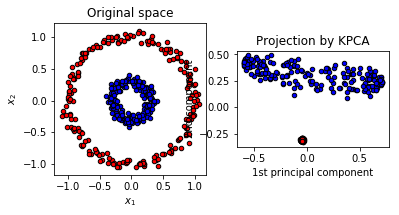

In [21]:
import matplotlib.pyplot as plt
plt.figure()

plt.subplot(1, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(XC[0, reds], XC[1, reds], c="red",
            s=20, edgecolor='k')
plt.scatter(XC[0, blues], XC[1, blues], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.subplot(1, 2, 2, aspect='equal')
plt.scatter(Xkpca[0, reds], Xkpca[1, reds], c="red",
            s=20, edgecolor='k')
plt.scatter(Xkpca[0, blues], Xkpca[1, blues], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")
plt.show()


## Results and Comments

We see clearly that by using kernel PCA we have seperated linearly in a feature space data that are not linearly in the first space, then when we project we see that we have a seperation see sckitlearn doc for more details http://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py